In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visual settings
sns.set(style="whitegrid")

# Load the dataset (Replace 'your_file.csv' with the actual name)
# We assume the date column needs parsing as per PDF "Analyze publication dates"
df = pd.read_csv('../data/news/raw_analyst_ratings.csv')

# Convert 'date' to datetime objects explicitly for Time Series analysis
# The PDF notes timezone info is present (UTC-4) [cite: 46]
df['date'] = pd.to_datetime(df['date'], errors='coerce')

print(df.head())
print(df.info())

   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

                       date stock  
0 2020-06-05 10:30:54-04:00     A  
1 2020-06-03 10:45:20-04:00     A  
2 2020-05-26 04:30:07-04:00     

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


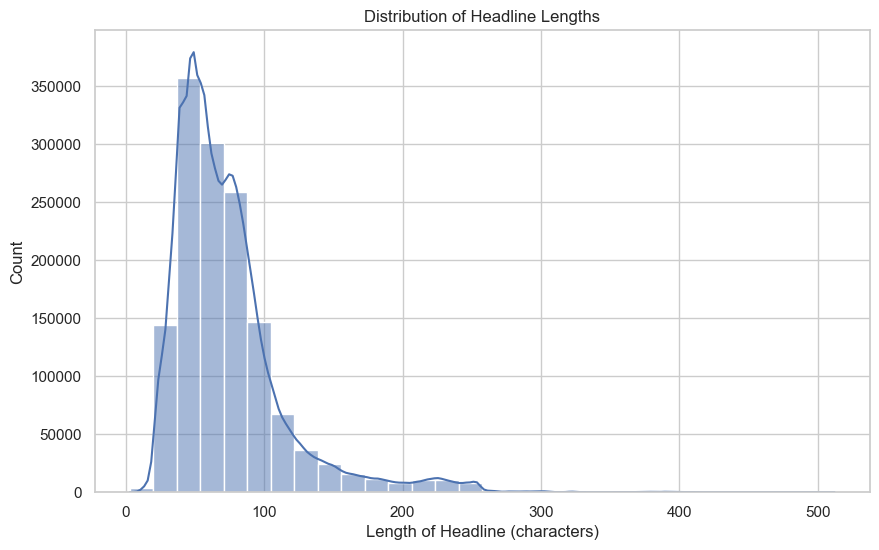

In [3]:
# Calculate the length of each headline
df['headline_length'] = df['headline'].apply(len)

# Display basic statistics (mean, min, max, std)
print(df['headline_length'].describe())

# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['headline_length'], bins=30, kde=True)
plt.title('Distribution of Headline Lengths')
plt.xlabel('Length of Headline (characters)')
plt.show()

Top 10 Publishers by Article Count:
publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
ETF Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


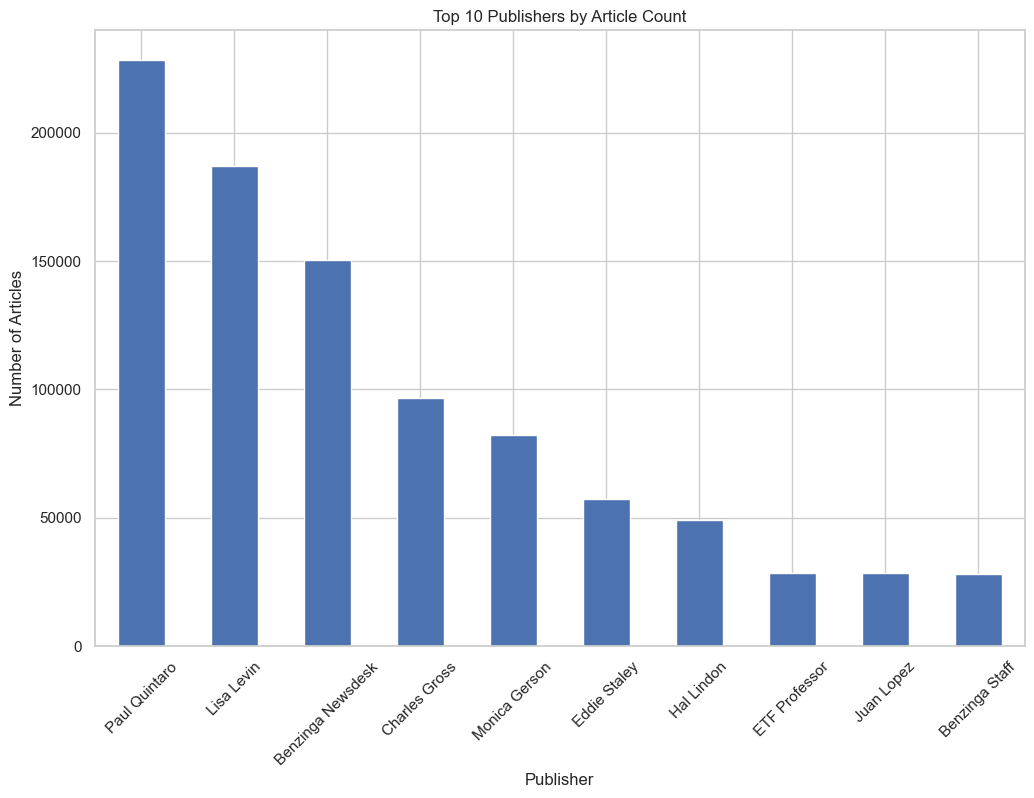

In [4]:
# Count articles per publisher
publisher_counts = df['publisher'].value_counts()

# Print top 10 publishers
print("Top 10 Publishers by Article Count:")
print(publisher_counts.head(10))

# Visualize the top publishers
plt.figure(figsize=(12, 8))
publisher_counts.head(10).plot(kind='bar')
plt.title('Top 10 Publishers by Article Count')
plt.xlabel('Publisher')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

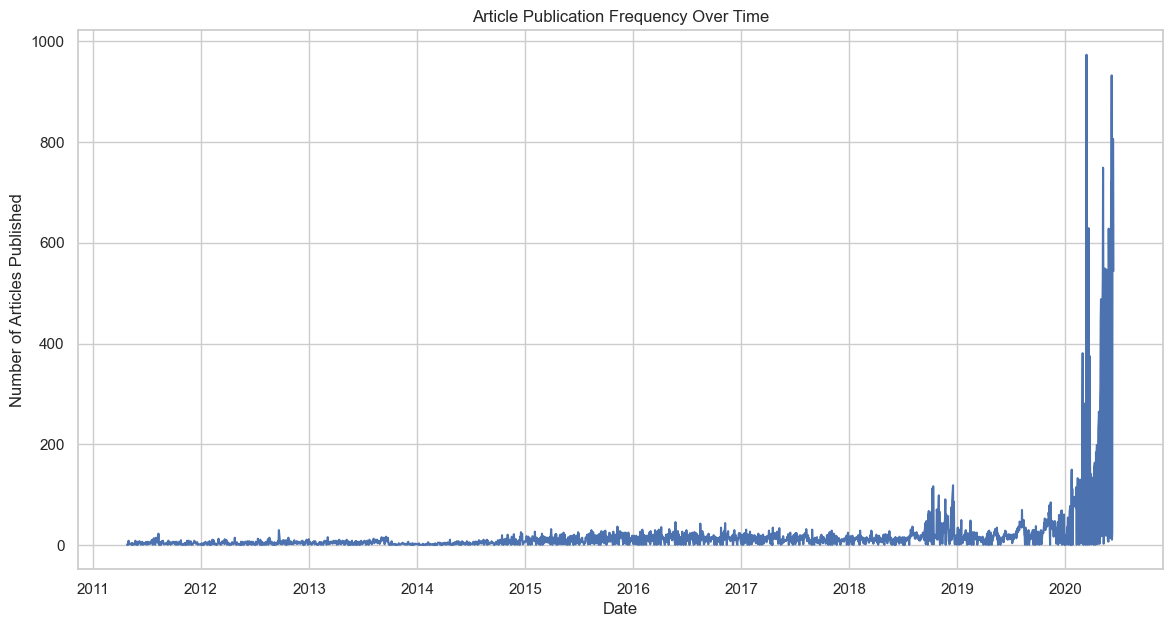

In [5]:
# Extract just the date (day) to see daily frequency
df['publication_day'] = df['date'].dt.date

# Count articles per day
daily_counts = df['publication_day'].value_counts().sort_index()

# Plot the trends over time
plt.figure(figsize=(14, 7))
daily_counts.plot(kind='line')
plt.title('Article Publication Frequency Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles Published')
plt.show()

/var/folders/vp/jp6dyn2x6v7dvrtdk8mn938r0000gn/T/ipykernel_72790/3519852157.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='publication_hour', data=df, palette='viridis')


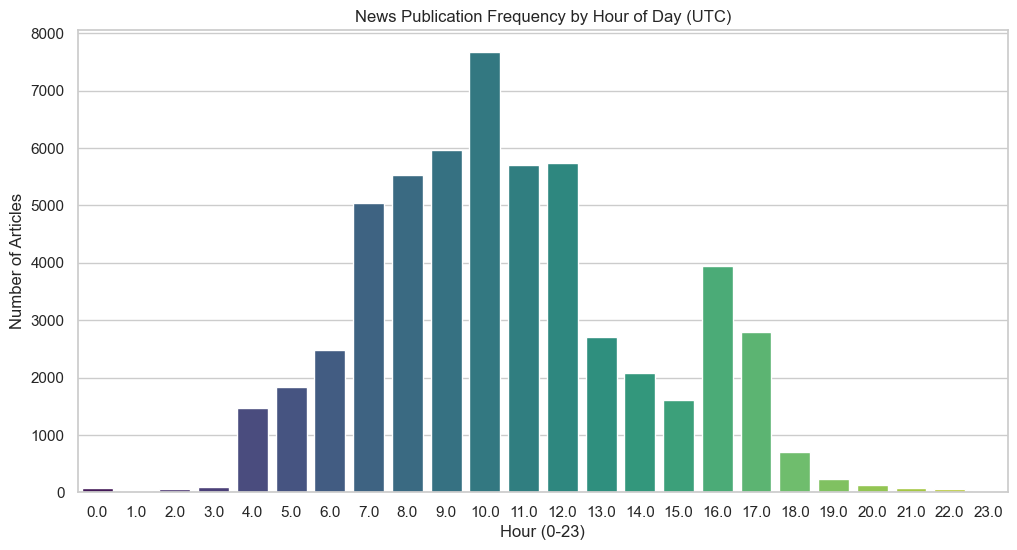

/var/folders/vp/jp6dyn2x6v7dvrtdk8mn938r0000gn/T/ipykernel_72790/3519852157.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='day_of_week', data=df, order=days_order, palette='muted')


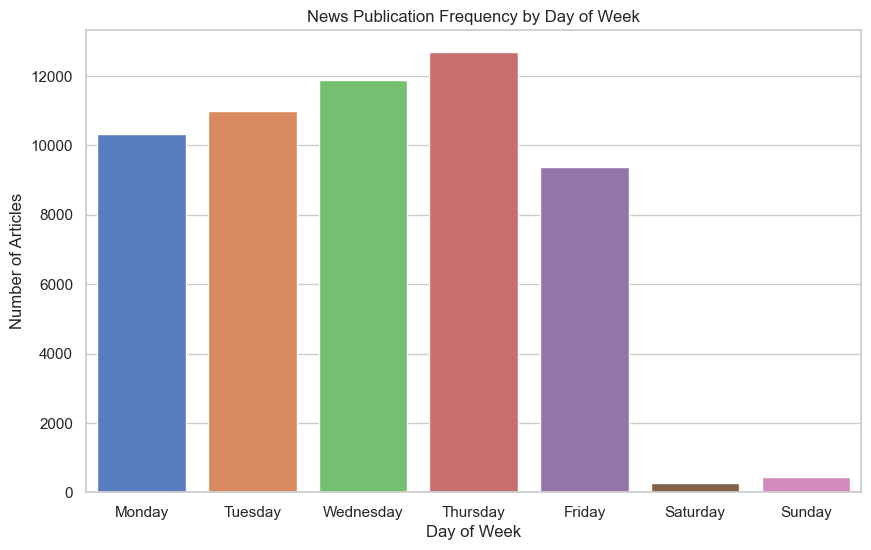

In [6]:
# Extract the hour and day of the week
# 'dt.hour' gives us 0-23, 'dt.day_name()' gives Monday, Tuesday, etc.
df['publication_hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.day_name()

# 1. Plot: At what time of day is news most frequent?
plt.figure(figsize=(12, 6))
sns.countplot(x='publication_hour', data=df, palette='viridis')
plt.title('News Publication Frequency by Hour of Day (UTC)')
plt.xlabel('Hour (0-23)')
plt.ylabel('Number of Articles')
plt.show()

# 2. Plot: Which days are busiest?
# We order them for a logical Mon-Sun plot
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=df, order=days_order, palette='muted')
plt.title('News Publication Frequency by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Articles')
plt.show()

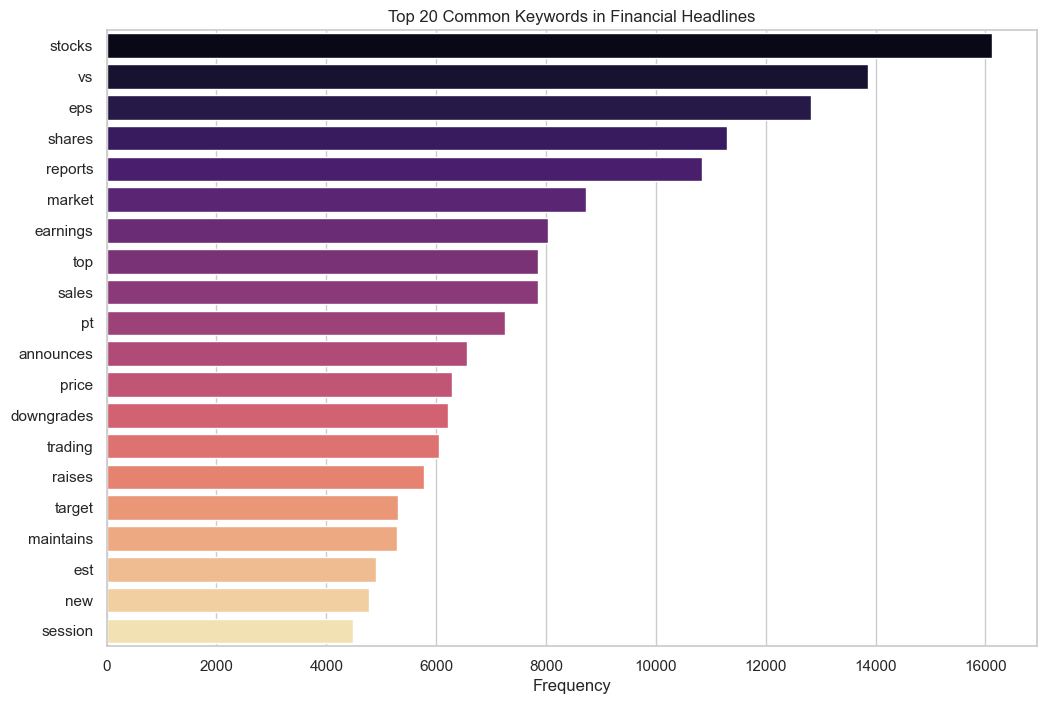

In [11]:
# Import NLP libraries
from collections import Counter
import nltk
from nltk.corpus import stopwords

# Download standard stopword list (run this once)
#nltk.download('stopwords')
#stop_words = set(stopwords.words('english'))

# Function to process text and count words
def get_top_keywords(text_series, top_n=20):
    all_words = []
    # Iterate through headlines (using a sample to speed it up if 1.4M is too slow)
    # We sample 100,000 rows for speed; remove .sample(100000) to use all data
    for headline in text_series.dropna().sample(frac=0.1, random_state=42):
        words = headline.lower().split()
        # Filter out stopwords and short words
        filtered_words = [word for word in words if word.isalnum() and word not in stop_words]
        all_words.extend(filtered_words)

    return Counter(all_words).most_common(top_n)
# Visualize top keywords
plt.figure(figsize=(12, 8))

# FIX: We added 'hue=list(keywords)' and 'legend=False'
sns.barplot(x=list(counts), y=list(keywords), hue=list(keywords), legend=False, palette='magma')

plt.title('Top 20 Common Keywords in Financial Headlines')
plt.xlabel('Frequency')
plt.show()